In [1]:
import ROOT as r
import copy
import math
import operator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
r.gStyle.SetPalette(r.kRainBow)
r.gStyle.SetOptStat(111111)
colors=[r.kBlue, r.kRed, r.kGreen, r.kOrange, r.kMagenta, r.kCyan, r.kViolet, r.kPink, r.kSpring, r.kTeal]

print(os.system('pwd'))


Welcome to JupyROOT 6.18/00
0


Open ouptut file form Alpaca ODAnalysis histogram

In [2]:
f=r.TFile('../../run/ODAnalysis/ODAnalysisAnalysis_DD.root')
def get_histo(file, histoname):
    histo=file.Get(histoname)
    return copy.deepcopy(histo)

def GetKeyNames( self, dir = "" ):
        self.cd(dir)
        return [key.GetName() for key in r.gDirectory.GetListOfKeys()]

r.TFile.GetKeyNames = GetKeyNames
keyList = f.GetKeyNames()
#print("\nKeys in file:", keyList)
histList=[]
for elem in keyList: 
        histList.append(elem)

def formatHisto(h, j, hname):
    h.SetMarkerStyle(7)
    h.SetMarkerColor(colors[j]+2)
    h.SetLineColor(colors[j]+2)
    h.SetLineWidth(2)
    h.SetMarkerColorAlpha(colors[j]+2,0.4)
    #h.SetFillColorAlpha(colors[j]+2,0.2)
    h.GetXaxis().SetTitleOffset(1.5);
    h.GetYaxis().SetTitleOffset(1.5);

    if 'vs' not in h.GetName(): 
        h.GetYaxis().SetTitle('Entries')
        h.GetXaxis().SetTitle(hname.replace('_', ' ').replace('ss',''))

    else:
        h.GetXaxis().SetTitle(hname.split('vs')[0].replace('_',' ').replace('ss',''))
        h.GetYaxis().SetTitle(hname.split('vs')[1].replace('_',' ').replace('ss',''))

legend = r.TLegend(0.75,0.75,0.89,0.89) 
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetFillColor(0)

def plotCuts(hlist, cuts):
    hlist=sorted(hlist)
    r.gStyle.SetOptStat(0)
    stack=r.THStack()
    hcols=3
    hlines=int(math.ceil(len(hlist)/hcols))
    c = r.TCanvas("c","c",hcols*600,hlines*600)
    c.Divide(hcols,hlines)
    for i, hname in enumerate(hlist):
        c.cd(i+1)
        if 'vs' not in hname: c.cd(i+1).SetLogy()
        legend.Clear()
        for j, cutname in enumerate(sorted(cuts)):
            h=get_histo(f, cutname+hname)
            if not get_histo(f, cutname+hname):
                    print(hname+' does not exist')
                    continue;
            formatHisto(h,j, hname)
            legend.AddEntry(h,cutname.replace('_',' '), 'l')
            stack.Add(h)
            option='SCAT'
            if 'vs' not in hname: 
                    c.cd(i+1).SetLogy()
                    option='histo'
                    if  h.Integral()>0:
                        h.Scale(1/h.Integral())
            h.Draw(option) if (i+j)<1 else h.Draw(option+' same')
            legend.Draw()
    return c

def plotSample(hlist, samples):
    hlist=sorted(hlist)
    r.gStyle.SetOptStat(0)
    stack=r.THStack()
    hcols=3
    hlines=int(math.ceil(len(hlist)/hcols))
    c = r.TCanvas("c","c",hcols*600,hlines*600)
    c.Divide(hcols,hlines)
    for i, hname in enumerate(hlist):
        legend.Clear()
        c.cd(i+1)
        #if 'vs' not in hname: c.cd(i+1).SetLogy()
        #c.cd(i+1).SetLogy()
        #c.cd(i+1).SetLogx()
        for j, sample in enumerate(samples):
            h=get_histo(sample, hname)
            if not get_histo(sample, hname):
                    print(hname+' does not exist')
                    continue;
            formatHisto(h,j, hname)
            legend.AddEntry(h,sample.GetPath().replace('.root:/','').split('_')[1], 'l')
            stack.Add(h)
            option='SCAT'
            if 'vs' not in hname:
                option='histo'
                if  h.Integral()>0:
                    h.Scale(1/h.Integral())
            h.Draw(option) if (j)<1 else h.Draw(option+' same')
            legend.Draw()
    return c

def cutflow(this, samples):
    data={}
    for i, sample in enumerate(samples):
        samplename=sample.GetPath().replace('.root:/','').split('_')[1]+": "
        entries=[]
        for j, cut in enumerate(sorted(cuts)):
            h=get_histo(sample, cut+'cutflow')
            entries.append(h.Integral())
            data.update({samplename:entries})
    df = pd.DataFrame(data, index = [s.replace('_', ' ') for s in sorted(cuts)]) 
    for i, key in enumerate(df.columns): 
        df['excl. eff. '+key]=round(df.iloc[:,i]/df.iloc[:,i].shift(1),3)
        df['incl. eff. '+key]=round(df.iloc[:,i]/df.iloc[0,i],3)
    return df

In [3]:
#define cuts and sets of histograms
#cuts={'cut0_presel_', 'cut1_ss_', 'cut2_s1_', 'cut3_s2_', 'cut4_r_', 'cut5_z_'}
#cuts={'cut1_ss_', 'cut2_s1_', 'cut3_s2_', 'cut4_r_', 'cut5_z_'}
cuts={'cut1_ss_', 'cut3_s2_', 'cut5_z_'}
plotsTPC1D={'tpc_HGpulses_n', 'tpc_ss_s1', 'tpc_ss_s2', 'tpc_ss_z', 'tpc_ss_r'}
plotsTPC2D={'tpc_ss_x_vs_y', 'tpc_ss_x_vs_z', 'tpc_ss_y_vs_z', 'tpc_ss_r_vs_z', 'tpc_ss_area_s1_vs_logs2s1'}
plotsOD1D={'od_HGpulses_n', 'od_pulseArea', 'od_leading_z', 'od_leading_phi', 'od_subleading_phi', 'od_leading_theta', 'od_subleading_z', 'od_subleading_theta', 
           'od_pulseStartTime_ns', 'od_coincidence', 'od_peakAmp', 'od_s1_diff_area', 'od_s1_diff_1sec_area', 'od_s1_diff_coinc', 'od_s1_diff_1sec_coinc', 'od_width', 'od_h2w', 'od_leading_pulse_area', 
           'od_subleading_pulse_area', 'od_subleading_leading_area_lsratio', 'od_pstart_leading_minus_subleading'}
#'od_subleading_area', 'od_subleading_area_id', 'od_max_area', 'od_max_area_id', 'od_max_coinc', 'od_max_coinc_id'
plotsOD2D={'od_area_vs_h2w', 'od_area_vs_width', 'od_peakAmp_vs_width', 'od_leading_peakAmp_vs_area', 'od_leading_area_vs_lsratio', 'od_leading_area_vs_coinc',
          'od_subleading_peakAmp_vs_area', 'od_subleading_area_vs_lsratio', 'od_subleading_area_vs_coinc', 'od_maxAreaID_vs_maxCoinID'}

In [4]:
#plotsTPC1D={'od_subleading_area', 'od_subleading_area_id'}
c=plotCuts(plotsTPC1D, cuts)
c.Draw()
c.SaveAs('tpc_1d_distributions.png')

Info in <TCanvas::Print>: png file tpc_1d_distributions.png has been created


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file tpc_2d_distributions.png has been created


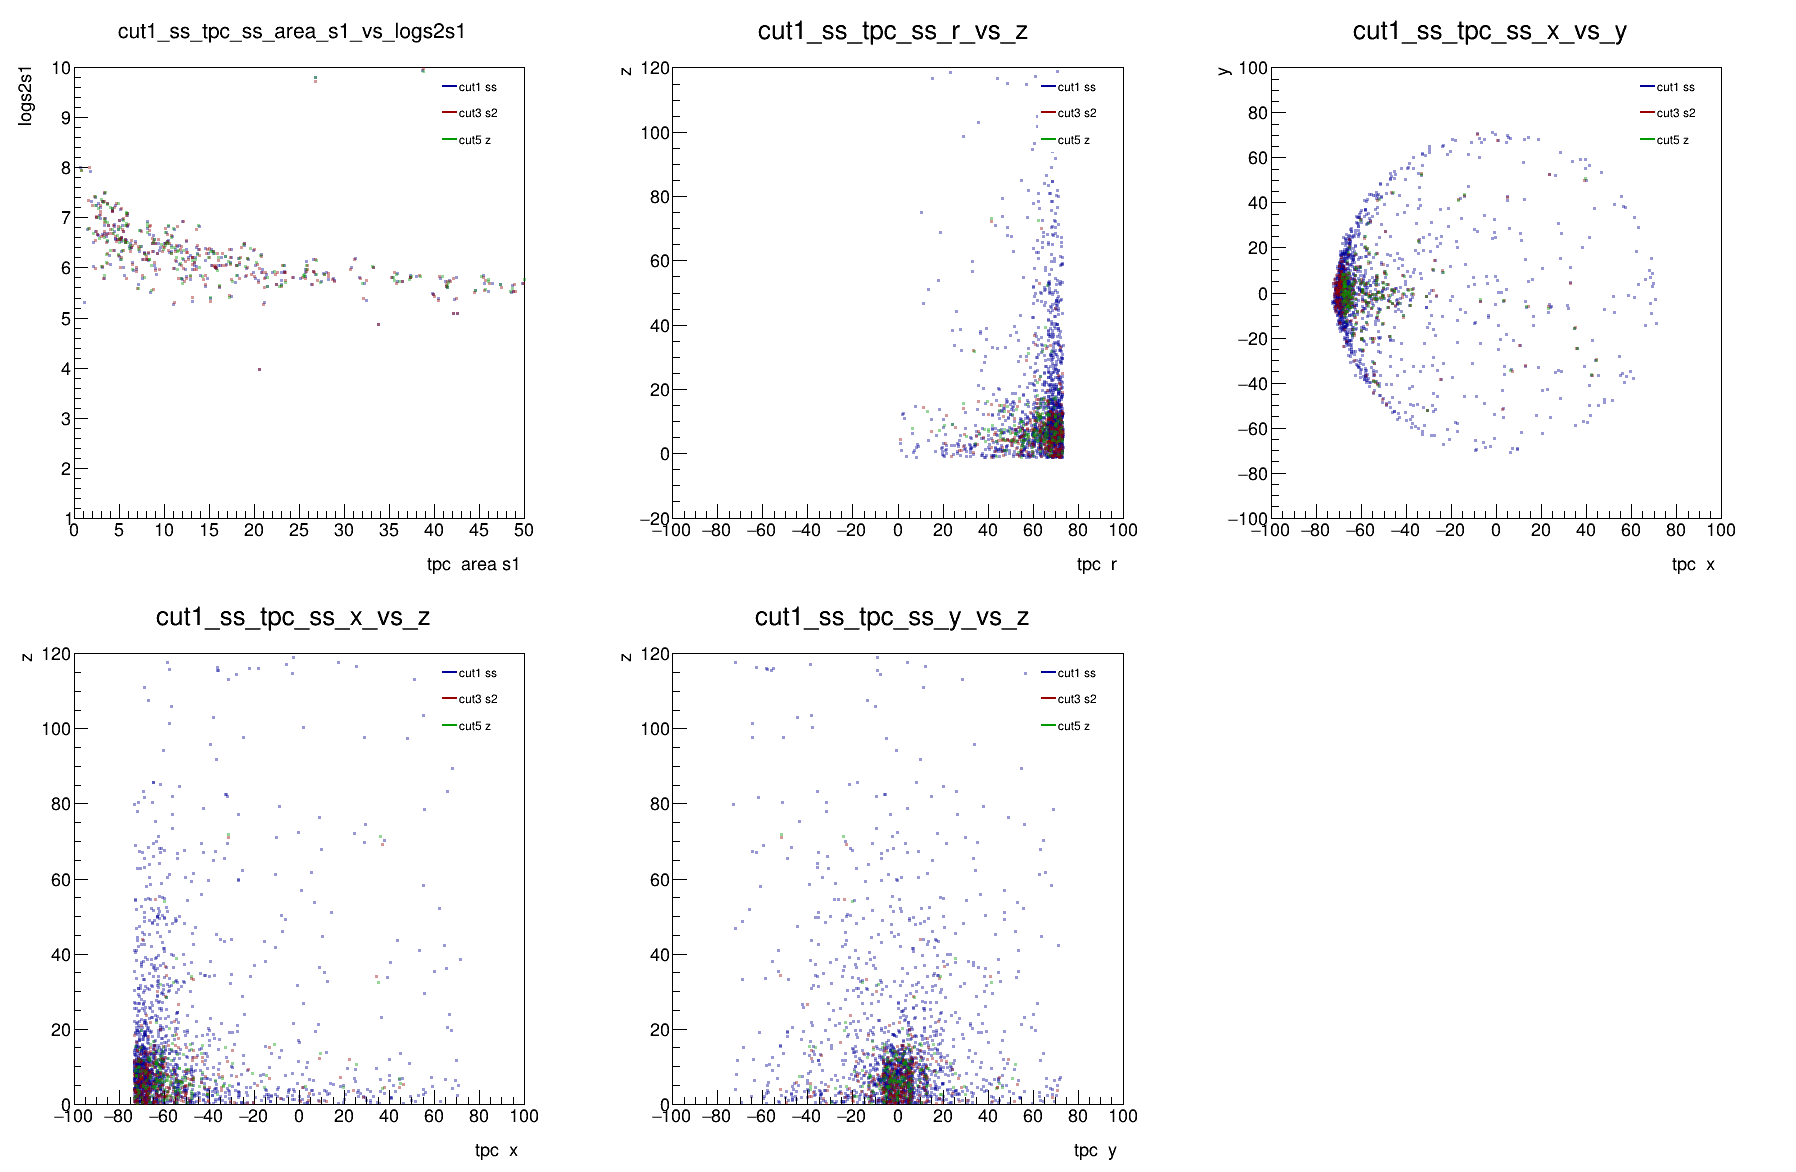

In [5]:
c=plotCuts(plotsTPC2D, cuts)
c.Draw()
c.SaveAs('tpc_2d_distributions.png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file od_1d_distributions.png has been created


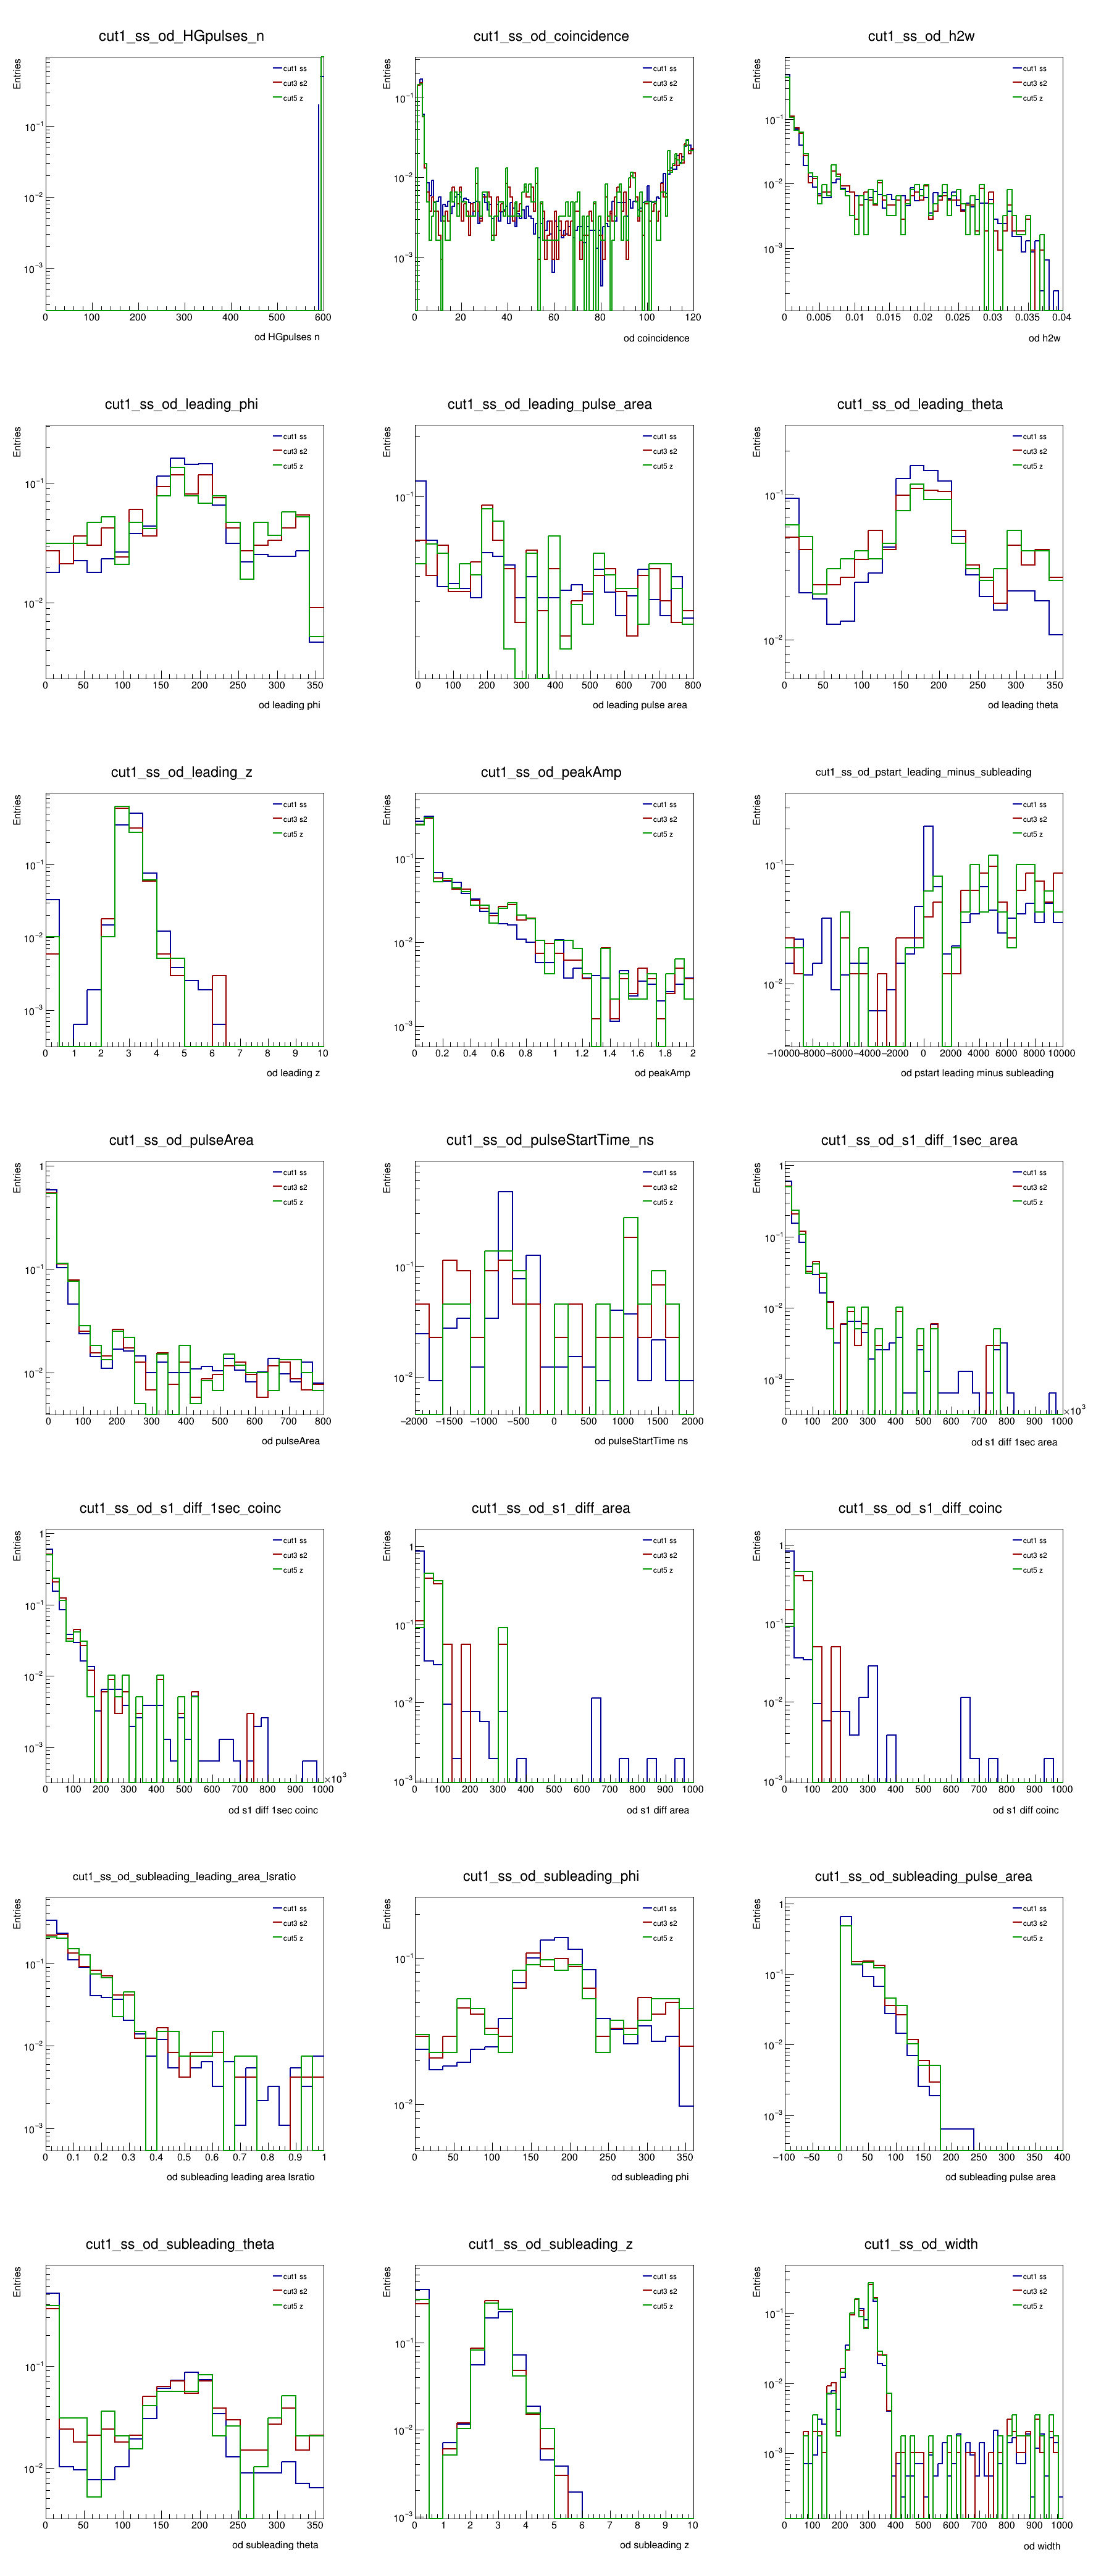

In [6]:
c=plotCuts(plotsOD1D, cuts)
c.Draw()
c.SaveAs('od_1d_distributions.png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file od_2d_distributions.png has been created


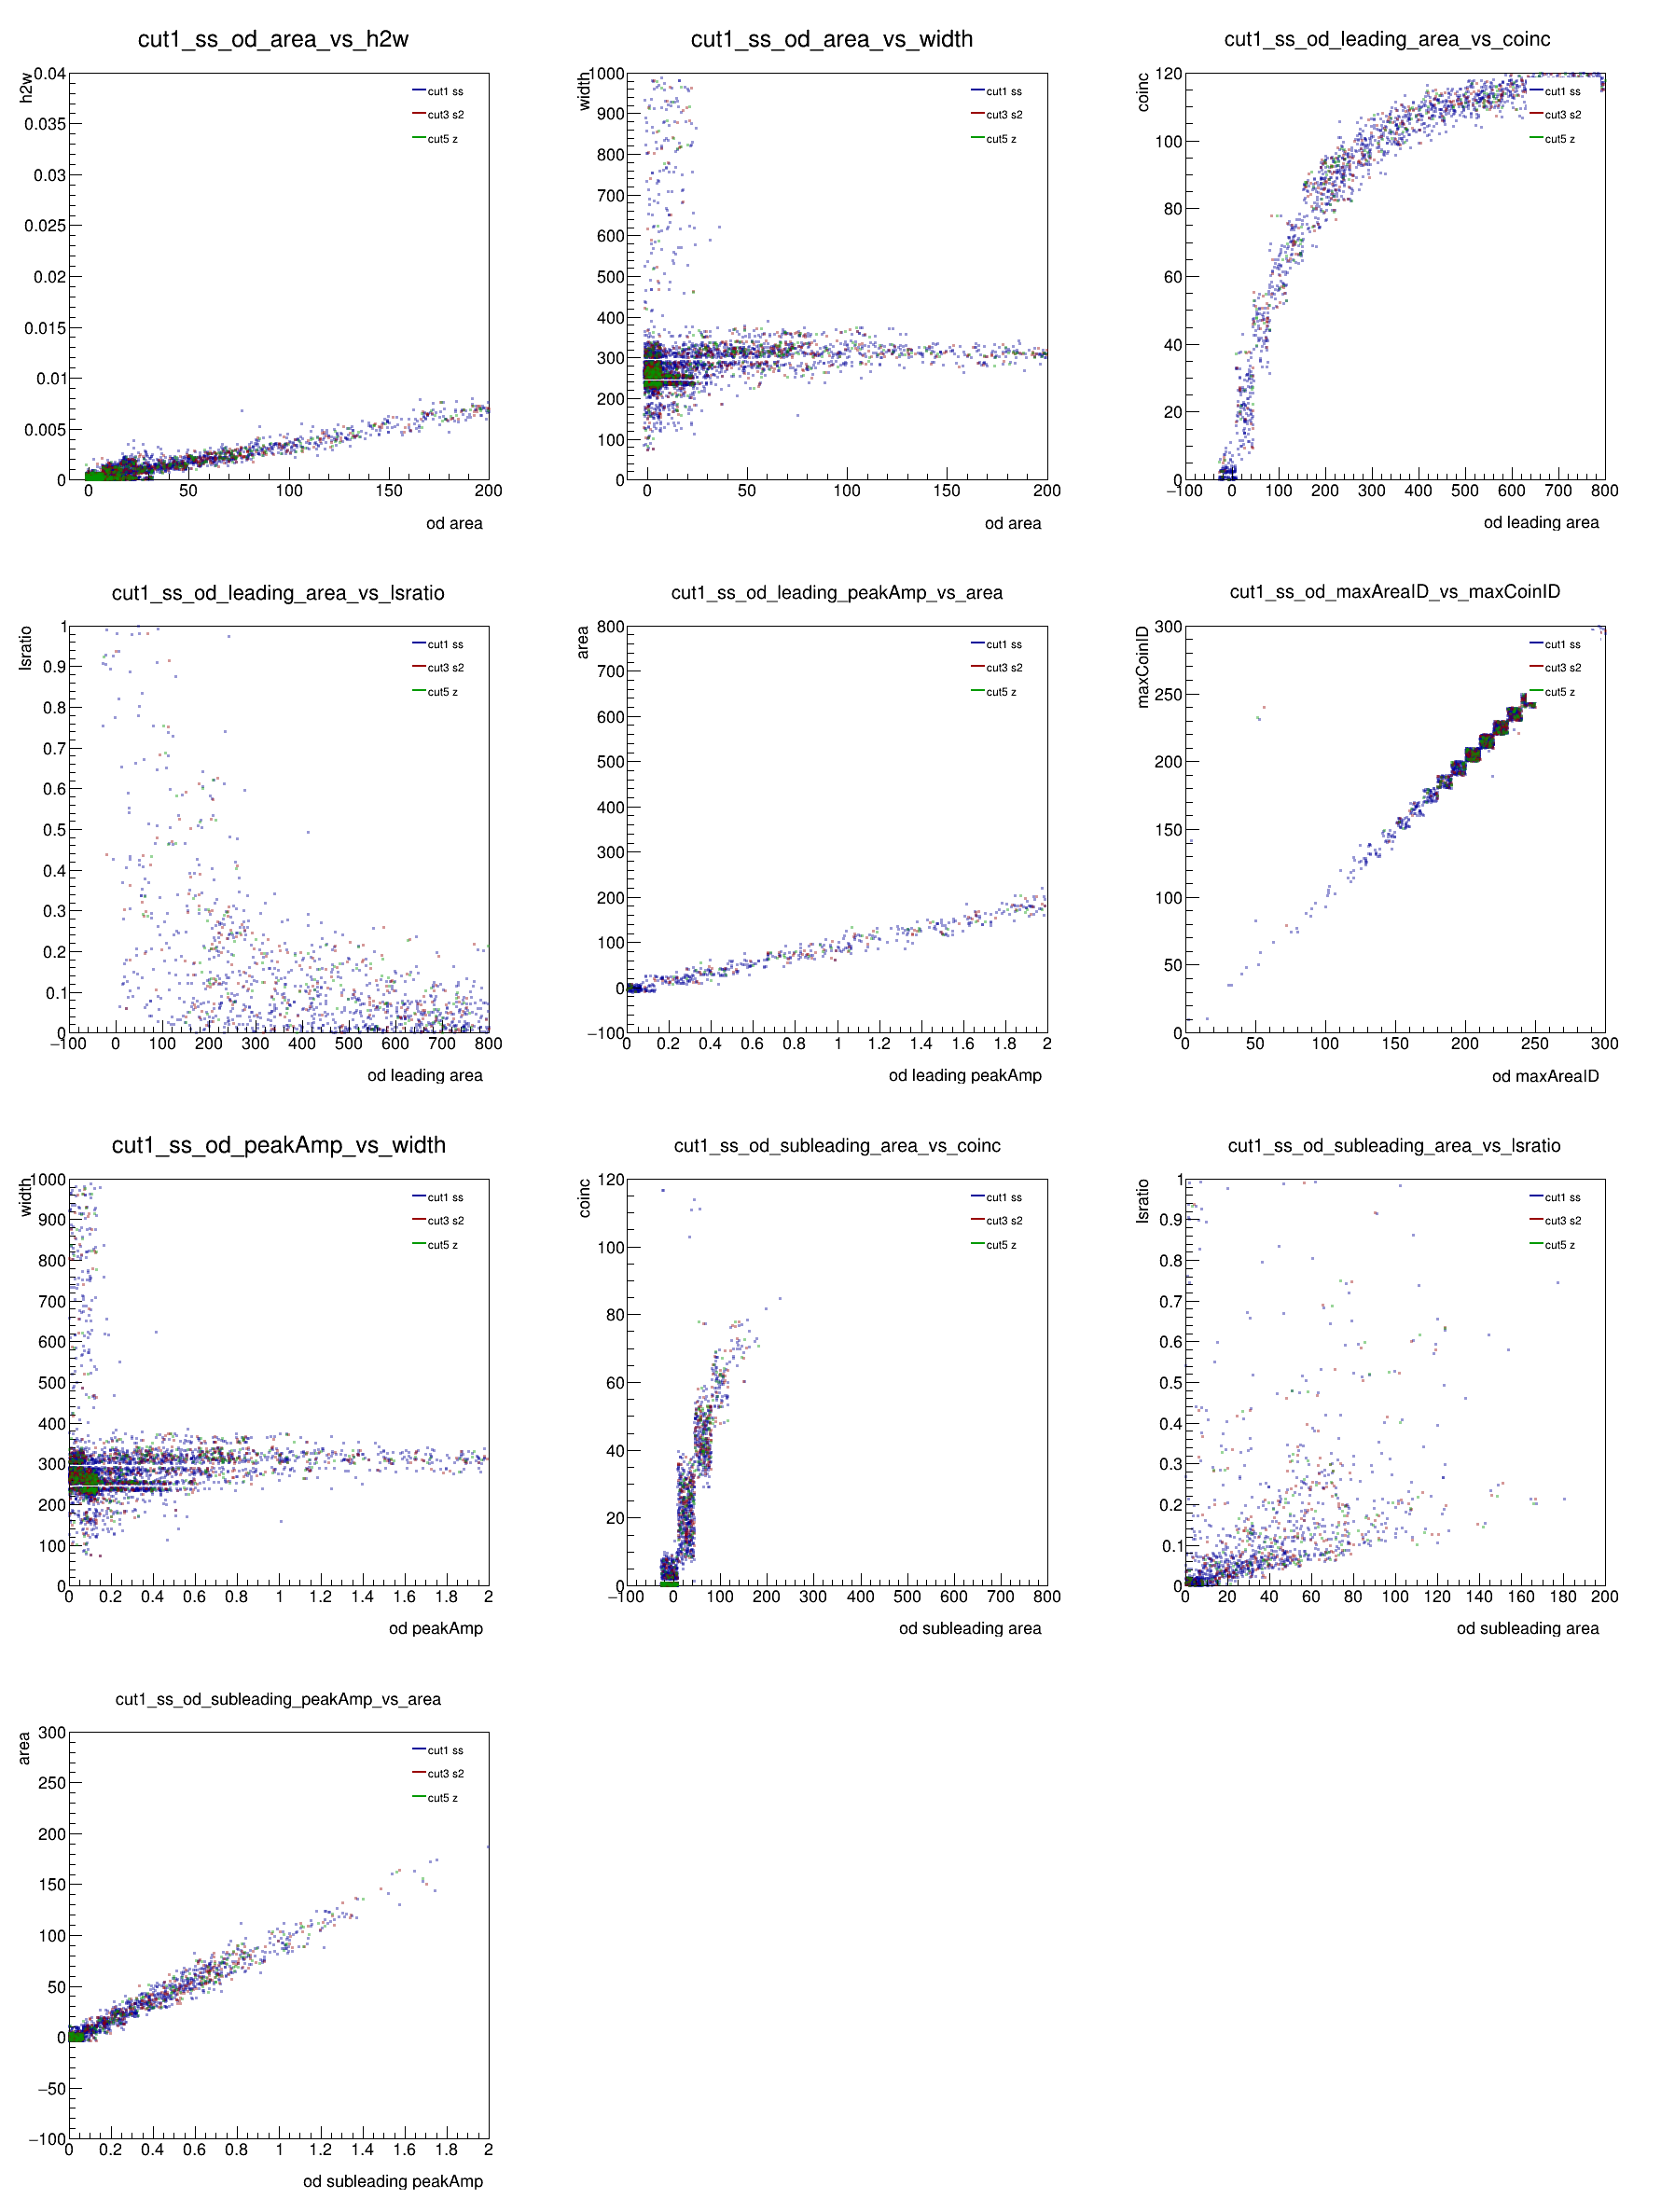

In [7]:
c=plotCuts(plotsOD2D, cuts)
c.Draw()
c.SaveAs('od_2d_distributions.png')

In [8]:
samples=[r.TFile('../../run/ODAnalysis/ODAnalysisAnalysis_DD.root'),
         r.TFile('../../run/ODAnalysis/ODAnalysisAnalysis_Wimp.root'),
         r.TFile('../../run/ODAnalysis/ODAnalysisAnalysis_NA22.root')]
c=plotSample([cut+s for s in plotsTPC1D], samples)
c.Draw()
c.SaveAs('tpc_1d_final_selection.png')

NameError: name 'cut' is not defined

In [ ]:
cut='cut1_ss_'
#cut='cut5_z_'
c=plotSample([cut+s for s in plotsTPC2D], samples)
c.Draw()
c.SaveAs('tpc_2d_final_selection.png')

In [ ]:
cut='cut5_z_'
#cut='cut1_ss_'
c=plotSample([cut+s for s in plotsOD1D], samples)
c.Draw()
c.SaveAs('od_1d_final_selection.png')

In [ ]:
cut='cut1_ss_'
c=plotSample([cut+s for s in plotsOD2D], samples)
c.Draw()
c.SaveAs('od_2d_final_selection.png')

In [ ]:
samples={r.TFile('../../run/ODAnalysis/ODAnalysisAnalysis_DD.root'),
         r.TFile('../../run/ODAnalysis/ODAnalysisAnalysis_Wimp.root'),
         r.TFile('../../run/ODAnalysis/ODAnalysisAnalysis_NA22.root')}
cuts={'cut0_presel_', 'cut1_ss_', 'cut2_s1_', 'cut3_s2_', 'cut4_r_', 'cut5_z_'}
df=cutflow(cuts, samples)  
df